In [58]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
from collections import deque
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import gymnasium as gym
import minigrid
from minigrid.wrappers import ImgObsWrapper, RGBImgPartialObsWrapper, RGBImgObsWrapper

import warnings
warnings.filterwarnings('ignore')

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: mps


<Axes: xlabel='step', ylabel='score'>

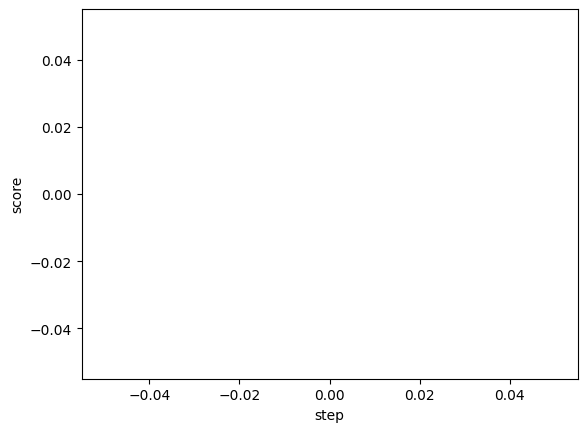

In [59]:
df = pd.read_csv('inference-uniform-DDQN-Minigrid-6x61.csv')
sns.lineplot(data=df, x='step',y='score')

<Axes: xlabel='step', ylabel='score'>

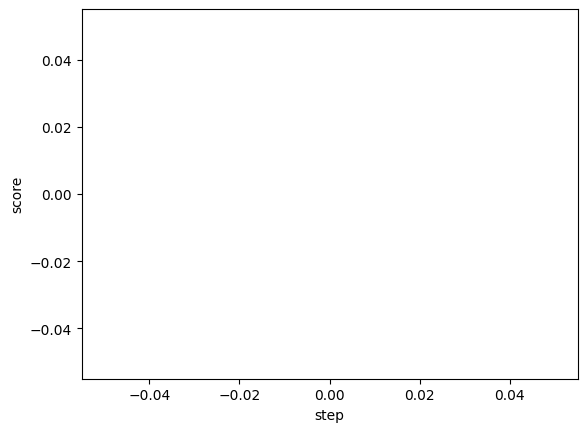

In [60]:
df = pd.read_csv('inference-uniform-DDQN-Minigrid-6x61.csv')
sns.lineplot(data=df, x='step',y='score')

In [61]:
class Qnet(nn.Module):
    def __init__(self, n_input_channels, n_actions):
        super(Qnet, self).__init__()
        self.conv1 = nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=2)
        self.batchnorm = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(2)
        self.mlp1 = nn.Linear(4160, 512)
        self.mlp2 = nn.Linear(512, n_actions)

    def forward(self, x):
        x = self.batchnorm(self.conv1(x))
        x = self.maxpool1(F.relu(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.mlp1(x))
        x = self.mlp2(x)
        return x

    def sample_action(self, obs, epsilon):
        obs = (torch.tensor(obs).permute(2, 0, 1) / 255.0).unsqueeze(0).to(device)
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0, 5)
        else:
            return out.argmax().item()

In [62]:
model = Qnet(3,6).to(device)
model.load_state_dict(torch.load('q-model-rgb-maxpool.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [63]:
def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = img

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    print(preds.argmax().item())
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())
    return slc.cpu().numpy()

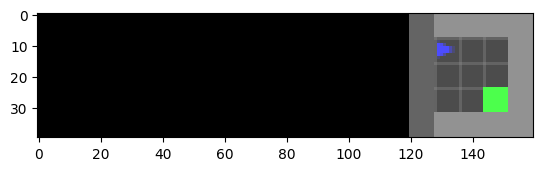

2


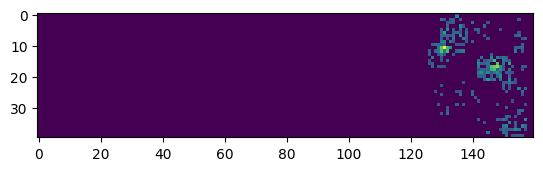

In [64]:
env = gym.make("MiniGrid-Empty-5x5-v0", render_mode="rgb_array")
env = RGBImgObsWrapper(env)  # Get pixel observations

# Convert image to greyscale, resize and normalise pixels
def preprocess(image, history):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # print(image.shape)
    # image = np.expand_dims(image, axis=2)
    # stack images
    history.popleft()
    history.append(image)
    image = np.concatenate(list(history), axis=1)
    return image

observation, info = env.reset()

# preprocess
img1 = np.zeros((40, 40, 3)).astype(np.uint8)
img2 = np.zeros((40, 40, 3)).astype(np.uint8)
img3 = np.zeros((40, 40, 3)).astype(np.uint8)
img4 = np.zeros((40, 40, 3)).astype(np.uint8)
history = deque([img1, img2, img3, img4])
observation_prime = preprocess(observation["image"], history)

plt.imshow(observation_prime)
plt.show()

observation_prime = (torch.tensor(observation_prime).permute(2, 0, 1) / 255.0).unsqueeze(0).to(device)

salient_map_original = saliency(observation_prime, model)
threshold = 0.25
salient_map_original = (salient_map_original > threshold) * salient_map_original
plt.imshow(salient_map_original);

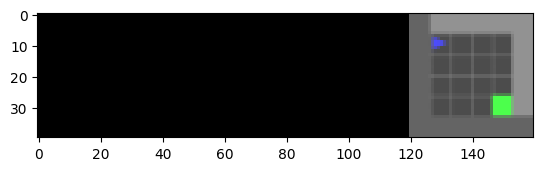

2


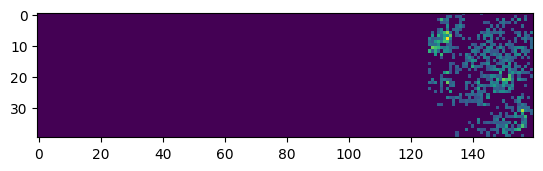

In [65]:
env = gym.make("MiniGrid-Empty-6x6-v0", render_mode="rgb_array")
env = RGBImgObsWrapper(env)  # Get pixel observations

# Convert image to greyscale, resize and normalise pixels
def preprocess(image, history):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (40, 40))
    history.popleft()
    history.append(image)
    image = np.concatenate(list(history), axis=1)
    return image

observation = env.reset()[0]
# preprocess
img1 = np.zeros((40, 40, 3)).astype(np.uint8)
img2 = np.zeros((40, 40, 3)).astype(np.uint8)
img3 = np.zeros((40, 40, 3)).astype(np.uint8)
img4 = np.zeros((40, 40, 3)).astype(np.uint8)
history = deque([img1, img2, img3, img4])
observation_prime = preprocess(observation["image"], history)

# observation_prime, reward, terminated, truncated, info = env.step(2)
# observation_prime = preprocess(observation_prime["image"], history)

# observation_prime, reward, terminated, truncated, info = env.step(2)
# observation_prime = preprocess(observation_prime["image"], history)

# observation_prime, reward, terminated, truncated, info = env.step(2)
# observation_prime = preprocess(observation_prime["image"], history)

# observation_prime, reward, terminated, truncated, info = env.step(2)
# observation_prime = preprocess(observation_prime["image"], history)
plt.imshow(observation_prime)
plt.show()

observation_prime = (torch.tensor(observation_prime).permute(2, 0, 1) / 255.0).unsqueeze(0).to(device)
salient_map_6x6 = saliency(observation_prime, model)
threshold = 0.25
salient_map_6x6 = (salient_map_6x6 > threshold) * salient_map_6x6
plt.imshow(salient_map_6x6);

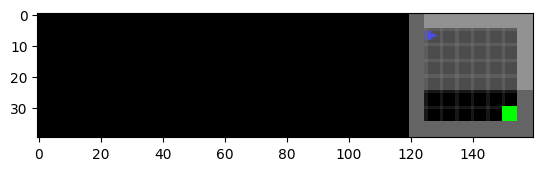

1
(40, 160, 3)


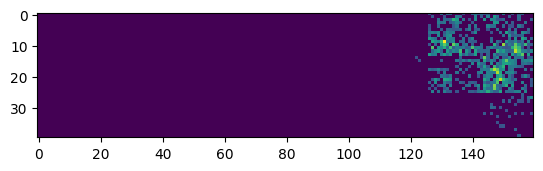

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(40, 160, 3)
(40, 160, 3)


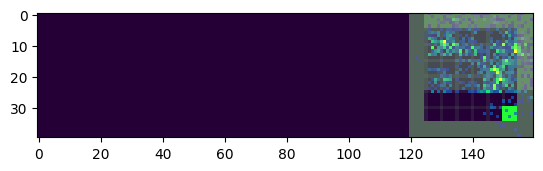

In [66]:
env = gym.make("MiniGrid-Empty-8x8-v0", render_mode="rgb_array")
env = RGBImgObsWrapper(env)  # Get pixel observations

# Convert image to greyscale, resize and normalise pixels
def preprocess(image, history):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (40, 40))
    history.popleft()
    history.append(image)
    image = np.concatenate(list(history), axis=1)
    return image

observation = env.reset()[0]
# preprocess
img1 = np.zeros((40, 40, 3)).astype(np.uint8)
img2 = np.zeros((40, 40, 3)).astype(np.uint8)
img3 = np.zeros((40, 40, 3)).astype(np.uint8)
img4 = np.zeros((40, 40, 3)).astype(np.uint8)
history = deque([img1, img2, img3, img4])
observation_prime = preprocess(observation["image"], history)

plt.imshow(observation_prime)
plt.show()

observation_prime = (torch.tensor(observation_prime).permute(2, 0, 1) / 255.0).unsqueeze(0).to(device)
salient_map_8x8 = saliency(observation_prime, model)
threshold = 0.25
salient_map_8x8 = (salient_map_8x8 > threshold) * salient_map_8x8
plt.imshow(salient_map_8x8)

salient_map_tensor = torch.from_numpy(salient_map_8x8)

# Resize saliency map to match the dimensions of the observation
resize = transforms.Resize((observation_prime.size(2), observation_prime.size(3)))
salient_map_resized = resize(salient_map_tensor)

# Convert the saliency map to a 3-channel image
viridis_salient_map = cm.viridis(salient_map_resized)

salient_map_rgb = viridis_salient_map[:, :, :3]

plt.imshow(salient_map_rgb)
plt.show()

# Apply overlay by blending the observation and the saliency map
overlay_observation = observation_prime.squeeze(0).detach().cpu().permute(1, 2, 0).numpy()  # Convert observation tensor to numpy array

# Define a blending factor (alpha) to control the intensity of the saliency map overlay
alpha = salient_map_rgb[:,:,:3][:,:,:np.newaxis] * 2
overlay = (1 - alpha) * overlay_observation + alpha * salient_map_rgb[:,:,:3]

# Display the overlay
plt.imshow(overlay)
plt.show()


In [67]:
mse_original_6x6 = np.mean((salient_map_original - salient_map_6x6)**2)
print(f"mse between original and 6x6: {mse_original_6x6}")

mse_original_8x8 = np.mean((salient_map_original - salient_map_8x8)**2)
print(f"mse between original and 8x8: {mse_original_8x8}")

mse between original and 6x6: 0.010127425193786621
mse between original and 8x8: 0.012113220989704132
